In [2]:
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
import sklearn
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM

In [3]:
#Function for pre-processing text to take out common words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Preprocessing steps
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    # Tokenization
    words = word_tokenize(text)
    # Removing punctuation and converting to lowercase
    words = [word.lower() for word in words if word.isalnum()]
    # Removing stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Skynet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Skynet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Skynet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('data_cleaned.csv')
df.dropna(subset=['Quote'], inplace=True)
# Display the first few rows of the DataFrame
df

,Movie Name,Actor Name,Character,Quote
0,Murderland,Ken Kushner,Teddy,Choose the doorway that starts you on your mag...
1,Murderland,Ken Kushner,Teddy,I didn't think he'd make it past Scraps.
2,Murderland,Ken Kushner,Teddy,Let's just see if he can make it into round tw...
3,Murderland,Ken Kushner,Teddy,Don't.
4,Murderland,Ken Kushner,Teddy,What ?
...,...,...,...,...
676435,Zulu Dawn,Burt Lancaster,Col. Durnford,MELVILL ride over this obstacle the Colours a...
676436,Zulu Dawn,Burt Lancaster,Col. Durnford,"For God's sake, hold them back! I'll get the h..."
676437,Zulu Dawn,Burt Lancaster,Col. Durnford,It's alright It's alright.
676438,Zulu Dawn,Burt Lancaster,Col. Durnford,hold the Colours aloft mockingly. Some ZULUS a...


In [5]:
#Define the top actors
actors_vc=df['Actor Name'].value_counts()
actors=actors_vc.index.to_list()
top_actors=actors[0:30]
print(actors_vc)
print(top_actors)


Robert De Niro       7448
Gene Hackman         6640
Nicolas Cage         5240
Jack Nicholson       4897
Denzel Washington    4661
                     ... 
Maurice Schutz        155
Corey Feldman         138
Victor Jory           105
Chad Everett           98
Julie Delpy            98
Name: Actor Name, Length: 668, dtype: int64
['Robert De Niro', 'Gene Hackman', 'Nicolas Cage', 'Jack Nicholson', 'Denzel Washington', 'Meg Ryan', 'Anthony Hopkins', 'Robert Duvall', 'Morgan Freeman', 'Brad Pitt', 'Michael Caine', 'George Clooney', 'Tom Wilkinson', 'Arnold Schwarzenegger', 'Harvey Keitel', 'Sigourney Weaver', 'Kurt Russell', 'Jeff Bridges', 'Tommy Lee Jones', 'Jason Bateman', 'Albert Brooks', 'Dan Aykroyd', 'DeForest Kelley', 'Susan Sarandon', 'Clint Eastwood', 'Michael Douglas', 'Christopher Plummer', 'Kevin Bacon', 'Robin Williams', 'William H. Macy']


In [6]:
#Create separate dataframe with only top actors
df_top_actors=df.loc[df["Actor Name"].isin(top_actors)]
df_top_actors['Actor Name'].value_counts()

Robert De Niro           7448
Gene Hackman             6640
Nicolas Cage             5240
Jack Nicholson           4897
Denzel Washington        4661
Meg Ryan                 4609
Anthony Hopkins          4166
Robert Duvall            4107
Morgan Freeman           4106
Brad Pitt                3931
Michael Caine            3810
George Clooney           3703
Tom Wilkinson            3551
Arnold Schwarzenegger    3445
Harvey Keitel            3445
Sigourney Weaver         3326
Kurt Russell             3289
Jeff Bridges             3228
Tommy Lee Jones          3101
Jason Bateman            3019
Albert Brooks            2986
Dan Aykroyd              2968
DeForest Kelley          2966
Susan Sarandon           2965
Clint Eastwood           2904
Michael Douglas          2859
Christopher Plummer      2846
Kevin Bacon              2809
Robin Williams           2758
William H. Macy          2741
Name: Actor Name, dtype: int64

In [7]:
# Apply preprocessing to the 'Quote' column of top actors dataframe
df_top_actors['Quote'] = df_top_actors['Quote'].apply(preprocess_text)
df_top_actors.dropna(subset=['Quote'], inplace=True)
df_top_actors=df_top_actors.reset_index(drop='True')
# preprocessed DataFrame value counts
df_top_actors.head()

c:\Users\Skynet\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Skynet\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Movie Name,Actor Name,Character,Quote
0,15 Minutes,Robert De Niro,Detective Eddie Flemming,say thing say open mouth
1,15 Minutes,Robert De Niro,Detective Eddie Flemming,fool around
2,15 Minutes,Robert De Niro,Detective Eddie Flemming,hear said
3,15 Minutes,Robert De Niro,Detective Eddie Flemming,want document trip america
4,15 Minutes,Robert De Niro,Detective Eddie Flemming,next could see document please


Absolute maximum Quote Length Is 270 Words
.995 Quantile (Used Maximum) Quote Length Is 43 Words


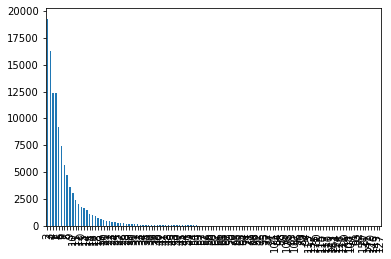

In [10]:
#count words in longest quote
def CountWords(text):
    return len(text.split())
df_top_actors['Quote Length']=df_top_actors['Quote'].apply(CountWords)
#Instead of absolute maximum, I went for .995 quantile to exclude outliers, which can be mapped in histogram
abs_max_quote_length=max(df_top_actors['Quote Length'])
max_quote_length=int(df_top_actors['Quote Length'].quantile(0.995))
#save max quote length so that other files can access it
max_quote_length_dic={'max_quote_length':max_quote_length}
with open('max_quote_length.pickle', 'wb') as handle:
        pickle.dump(max_quote_length_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)
#print and display 
print(f"Absolute maximum Quote Length Is {abs_max_quote_length} Words")
print(f".995 Quantile (Used Maximum) Quote Length Is {max_quote_length} Words")    
df_top_actors['Quote Length'].value_counts().plot(kind='bar')

In [11]:
#Tokenize and pad the quote word sequences
tokenizer = Tokenizer(num_words=10000)  # Adjust based on your vocabulary size
tokenizer.fit_on_texts(df_top_actors['Quote'])  # texts should be your input data
sequences = tokenizer.texts_to_sequences(df_top_actors['Quote'])  # Convert text to integer sequences
X_count = pad_sequences(sequences, maxlen=max_quote_length)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Encode the target labels and save classes as separate file
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_top_actors['Actor Name'])
np.save('classes.npy', label_encoder.classes_)

In [13]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_count, y_encoded, test_size=0.2, random_state=42)


In [14]:
# Initialize the model
e = Embedding(10000, 64, input_length=max_quote_length)
batch_size=64
model = Sequential()
model.add(e)
model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))
model.add(Dense(30, activation = 'softmax' ))
model.summary()
model.compile( optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'] )
#define callbacks
early_stopper = EarlyStopping( monitor = 'accuracy' , min_delta = 0.0005, patience = 3 )
reduce_lr = ReduceLROnPlateau( monitor = 'loss' , patience = 2 , cooldown = 0)
callbacks = [ reduce_lr , early_stopper]
#fit and evaluate model
model.fit( X_train , y_train , batch_size = batch_size, epochs = 10, verbose = 1 , callbacks = callbacks)
score = model.evaluate( X_test , y_test , batch_size = batch_size)

print( "Accuracy: {:0.4}".format( score[1] ))

print( "Loss:", score[0] )



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
Total params: 742,686
Trainable params: 742,686
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1407/1407 [==============================] - 44s 31ms/step - loss: 3.1407 - accuracy: 0.1386 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 44s 31ms/step - loss: 2.5809 - accuracy: 0.3063 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 45s 32ms/step - loss: 2.

In [15]:
# Make predictions
y_pred_all = model.predict(X_test)
y_pred=[]
for i in y_pred_all:
    i=list(i)
    y_pred.append(i.index(max(i)))
print(y_test)
print(y_pred)
# Calculate accuracy
accuracy = accuracy_score(list(y_test), y_pred)
print(f"Accuracy: {accuracy:.2f}")

704/704 [==============================] - 4s 5ms/step
[15 23 11 ...  8  2 14]
[21, 9, 27, 9, 22, 26, 6, 22, 8, 9, 7, 9, 3, 16, 3, 14, 10, 22, 13, 22, 24, 25, 22, 3, 22, 22, 7, 7, 1, 15, 7, 6, 22, 9, 4, 3, 0, 13, 3, 5, 9, 2, 21, 24, 8, 23, 17, 22, 22, 12, 26, 18, 12, 9, 22, 1, 21, 22, 23, 11, 9, 2, 1, 22, 10, 5, 24, 12, 0, 2, 22, 11, 9, 23, 15, 0, 9, 9, 23, 18, 16, 25, 7, 19, 19, 14, 29, 11, 17, 9, 17, 5, 9, 15, 11, 22, 23, 14, 20, 21, 11, 8, 26, 19, 11, 18, 5, 20, 12, 8, 27, 8, 7, 23, 22, 22, 13, 23, 20, 12, 13, 9, 21, 0, 13, 11, 17, 17, 22, 12, 9, 6, 12, 29, 24, 9, 19, 29, 22, 2, 9, 26, 22, 21, 24, 7, 13, 15, 9, 23, 9, 0, 15, 3, 3, 8, 1, 21, 12, 22, 22, 20, 18, 13, 21, 12, 14, 1, 25, 1, 7, 3, 2, 9, 18, 9, 21, 25, 2, 22, 5, 22, 8, 12, 23, 8, 9, 22, 16, 8, 22, 25, 26, 16, 16, 21, 13, 16, 22, 23, 17, 5, 12, 22, 18, 21, 27, 3, 9, 19, 21, 27, 17, 21, 21, 16, 24, 25, 16, 28, 6, 21, 9, 22, 0, 28, 21, 16, 19, 2, 21, 17, 8, 26, 8, 7, 22, 9, 21, 17, 4, 11, 24, 21, 8, 16, 23, 17, 8, 21, 20, 22,

In [16]:
model.save("LSTM_actor_quotes_model.h5")

In [17]:
#Program for predicting actor from quote using the model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

def ActorPredictor(phrase):
    phrase_ls=[]
    for i in phrase:
        phrase_ls.append(preprocess_text(i))
    tokenizer = Tokenizer(num_words=10000)  # Adjust based on your vocabulary size
    #tokenizer.fit_on_texts(df_top_actors['Quote'])  # texts should be your input data
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)
    sequences = tokenizer.texts_to_sequences(phrase_ls)  # Convert text to integer sequences
    phrase_count = pad_sequences(sequences, maxlen=max_quote_length)
    actors_pred_all = model.predict(phrase_count)
    actors_pred=[]
    for i in actors_pred_all:
        i=list(i)
        actors_pred.append(i.index(max(i)))
    return label_encoder.inverse_transform(actors_pred)
    #return sequences

In [18]:
#Sample implementation of the program
ActorPredictor(["terminator"])


1/1 [==============================] - 0s 10ms/step


array(['Arnold Schwarzenegger'], dtype=object)